In [1]:
import socket
import platform
import psutil

system = platform.system()
release = platform.release()

processor = platform.processor()

memory = psutil.virtual_memory()
total_memory = memory.total

print("System:", system)
print("Release:", release)
print("Processor:", processor)
print("Total Memory (bytes):", total_memory)

hostname = socket.gethostname()
ip_address = socket.gethostbyname(hostname)
print(f"Hostname : {hostname}")
print(f"IP Address : {ip_address}")

System: Windows
Release: 10
Processor: Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
Total Memory (bytes): 17053241344
Hostname : DESKTOP-MPK8KBE
IP Address : 192.168.1.169


In [2]:
import pandas as pd
from pyspark.sql.functions import desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
from pyspark.sql.functions import col, isnan, when, count

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand

spark = SparkSession.builder.appName('your_app').getOrCreate()

df = spark.read.csv("NetflixData.csv", header = True, inferSchema=True)

df = df.orderBy(rand()).limit(500000)

In [4]:
from pyspark.sql.functions import split

new_column_names = df.columns

df_split = df.select(*[split(col(c), ",").alias(f"{c}") for c in new_column_names])

df_split.show(truncate=False)

+--------+------+-------------------------------------+---------+------+
|Movie_ID|Year  |Name                                 |User_ID  |Rating|
+--------+------+-------------------------------------+---------+------+
|[331]   |[1997]|[Chasing Amy]                        |[1709569]|[3]   |
|[191]   |[2003]|[X2: X-Men United]                   |[1676266]|[4]   |
|[175]   |[1992]|[Reservoir Dogs]                     |[527898] |[5]   |
|[313]   |[2000]|[Pay It Forward]                     |[1644832]|[3]   |
|[290]   |[2004]|[Harold and Kumar Go to White Castle]|[2532733]|[4]   |
|[275]   |[2002]|[Evelyn]                             |[1700270]|[3]   |
|[148]   |[2001]|[Sweet November]                     |[941092] |[5]   |
|[197]   |[2004]|[Taking Lives]                       |[637533] |[4]   |
|[191]   |[2003]|[X2: X-Men United]                   |[568194] |[4]   |
|[30]    |[2003]|[Something's Gotta Give]             |[2008554]|[3]   |
|[358]   |[1979]|[The Onion Field]                 

In [5]:
mean_rating = df.rdd.map(lambda row: row['Rating']).reduce(lambda x, y: x + y) / df.count()
print(mean_rating)
#Average Rating of All Users

3.606266


In [6]:
user_id = int(input("Enter a User ID :"))

ratings = df.rdd.filter(lambda row: row['User_ID'] == user_id).map(lambda row: row['Rating'])
rating_sum = ratings.reduce(lambda x, y: x + y)
rating_count = ratings.count()

if rating_count > 0:
    mean_rating = rating_sum / rating_count
    print("Average Rating:", mean_rating)
else:
    print("No rating found for the specified User ID.")
#Average Rating of Inputed User

Enter a User ID :1676266
Average Rating: 3.3333333333333335


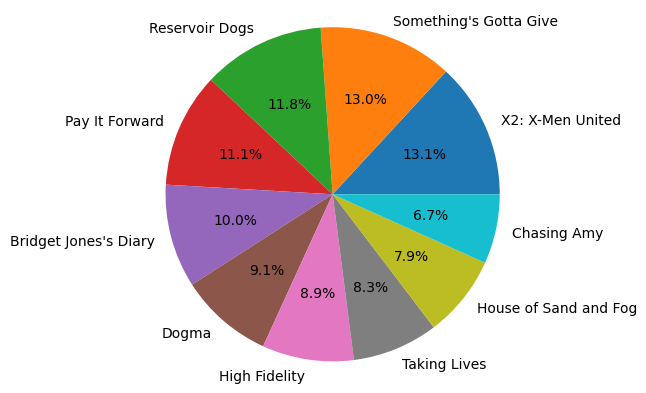

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = df.toPandas()

grouped_df = pandas_df.groupby('Name')['Rating'].sum().reset_index()
top_10_years = grouped_df.nlargest(10, 'Rating')

plt.pie(top_10_years['Rating'], labels=top_10_years['Name'], autopct='%1.1f%%')
plt.axis('equal')
plt.show()

##en çok oylanan filmler ve oylanma yüzdeleri

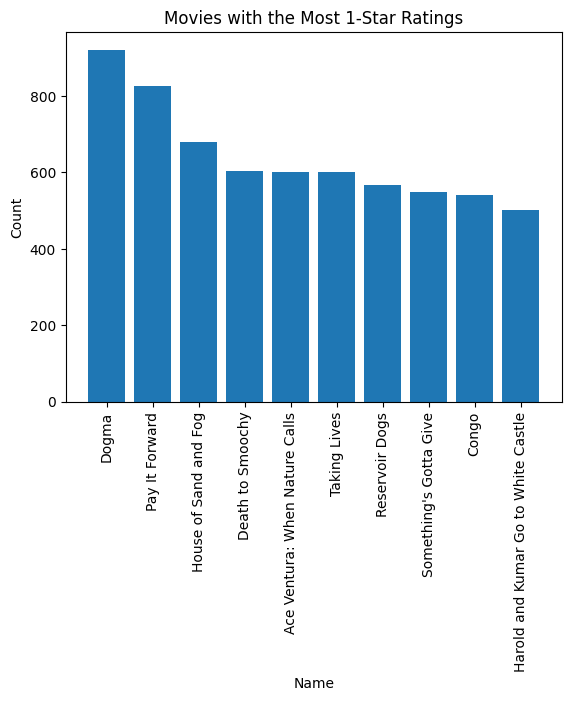

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = df.toPandas()

top_10_movies = pandas_df[pandas_df['Rating'] == 1].groupby('Name').size().nlargest(10).reset_index()
top_10_movies.columns = ['Name', 'Count']

plt.bar(top_10_movies['Name'].astype(str), top_10_movies['Count'])
plt.xlabel('Name')
plt.ylabel('Count')
plt.title('Movies with the Most 1-Star Ratings')
plt.xticks(rotation=90)
plt.show()
##en çok 1 puan almıs filmler ve 1 puan alma sayıları

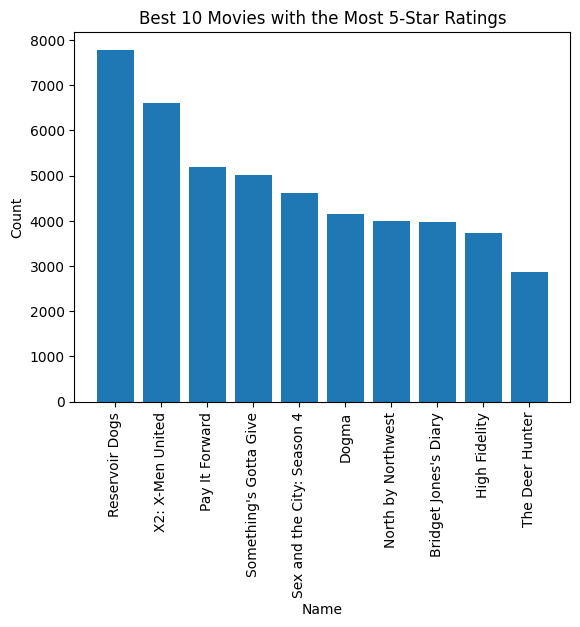

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = df.toPandas()

top_10_movies = pandas_df[pandas_df['Rating'] == 5].groupby('Name').size().nlargest(10).reset_index()
top_10_movies.columns = ['Name', 'Count']

plt.bar(top_10_movies['Name'].astype(str), top_10_movies['Count'])
plt.xlabel('Name')
plt.ylabel('Count')
plt.title('Best 10 Movies with the Most 5-Star Ratings')
plt.xticks(rotation=90)
plt.show()

##en çok 5 puan almıs filmler ve 5 puan alma sayıları

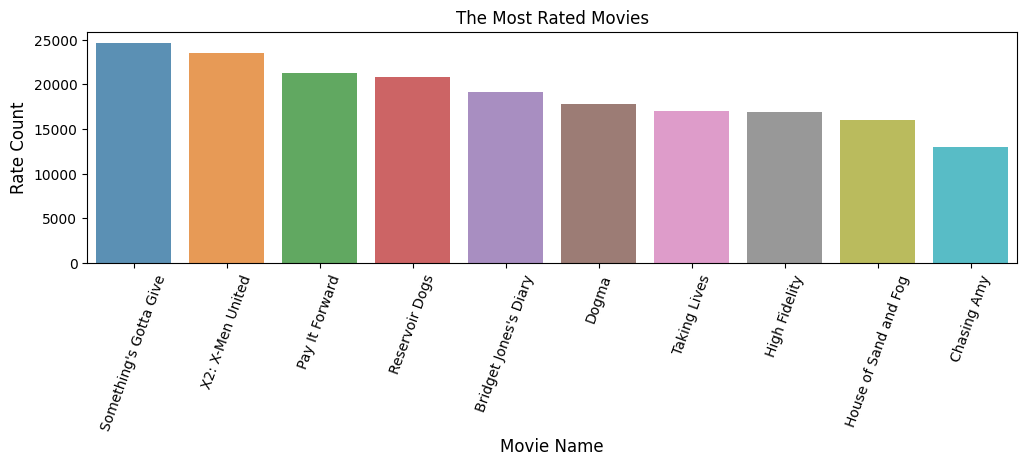

In [10]:
top_rated = df.groupBy("Name").count().orderBy(desc("count")).limit(10)

top_rated_pd = top_rated.toPandas()

plt.figure(figsize=(12,3))
sns.barplot(x='Name', y='count', data=top_rated_pd, alpha=0.8)
plt.title('The Most Rated Movies')
plt.ylabel('Rate Count', fontsize=12)
plt.xlabel('Movie Name', fontsize=12)
plt.xticks(rotation=70)
plt.show()
##en cok puanlama yapılmıs filmler

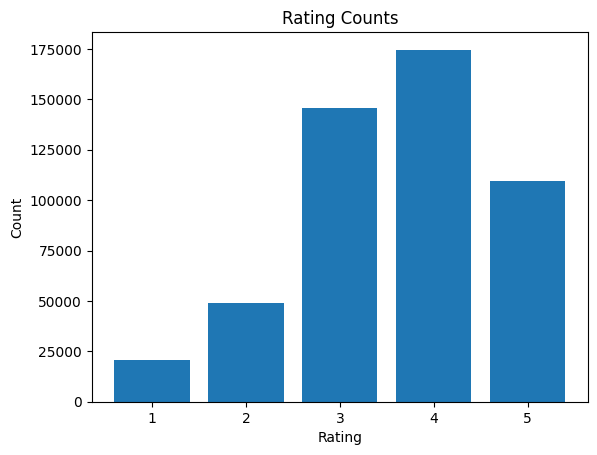

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

pandas_df = df.toPandas()

rating_counts = pandas_df['Rating'].value_counts().sort_index().reset_index()
rating_counts.columns = ['Rating', 'Count']

plt.bar(rating_counts['Rating'].astype(str), rating_counts['Count'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Counts')
plt.show()


##hangi rating kaç kere kullanılmıs

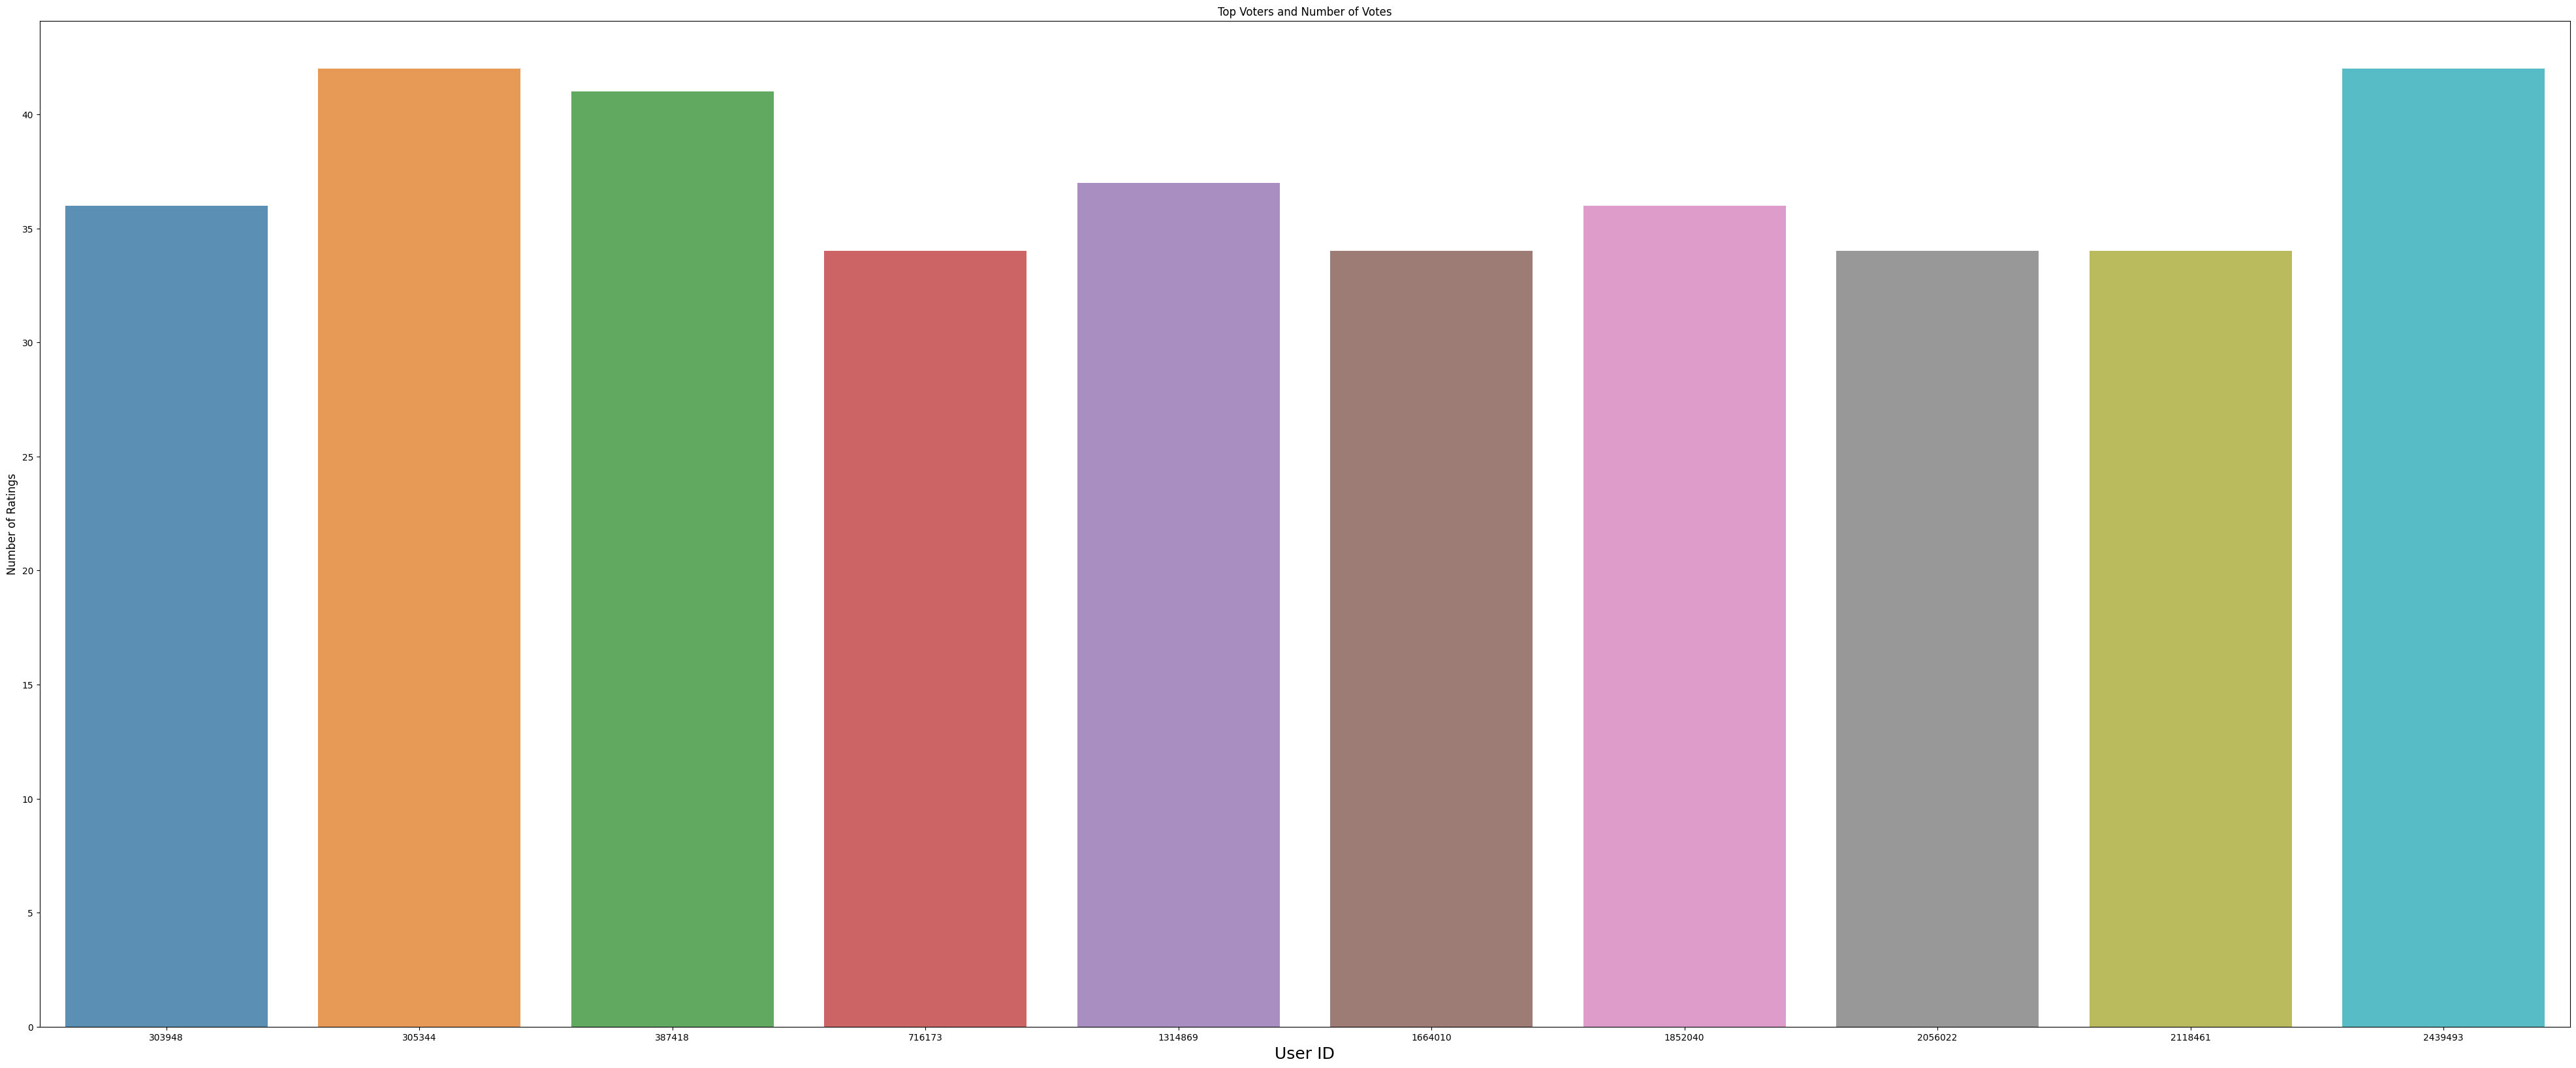

In [12]:
top_rated = df.groupBy("User_ID").count().orderBy(desc("count")).limit(10)

top_rated_pd = top_rated.toPandas()

plt.figure(figsize=(50,20))
sns.barplot(x='User_ID', y='count', data=top_rated_pd, alpha=0.8)
plt.title('Top Voters and Number of Votes')
plt.ylabel('Number of Ratings', fontsize=12)
plt.xlabel('User ID' , fontsize=18)
plt.show()
# en cok derecelendirme yapan kullanıcılar ve oy kullanma sayıları

In [13]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession

training_data, test_data = df.randomSplit([0.7, 0.3], seed=5064)

rank_values = [10, 50, 200]
iteration_values = [1, 5, 20]
lambda_values = [0.01, 0.1]


models = []
for rank in rank_values:
    for iteration in iteration_values:
        for lambd in lambda_values:
            als = ALS(rank=rank, maxIter=iteration, regParam=lambd, userCol='User_ID', itemCol='Movie_ID', ratingCol='Rating', seed=5080, coldStartStrategy="drop")
            trained_model = als.fit(training_data)
            models.append(trained_model)


print(models)

[ALS_67dc3018ec83, ALS_ec2f33f8c1b8, ALS_0b091e615f48, ALS_64d15ae1a5b0, ALS_7f5153eea5c5, ALS_b617f5cf9e55, ALS_63de1ef8b47d, ALS_5a345d2d2c8b, ALS_a550efaba091, ALS_93e42f00a434, ALS_8e7a12d081ed, ALS_dc1a4f3a6a08, ALS_1f11b082512d, ALS_34c4e695f431, ALS_8a6602f6ca42, ALS_225cffd95582, ALS_71492501a4e9, ALS_bff5c48f598b]


In [14]:
from pyspark.ml.evaluation import RegressionEvaluator

rmse_values = []
mse_values = [] 
evaluator_rmse = RegressionEvaluator(metricName='rmse', labelCol='Rating', predictionCol='prediction')
evaluator_mse = RegressionEvaluator(metricName='mse', labelCol='Rating', predictionCol='prediction')

best_model = None
best_rmse = float('inf')

for model in models:
    predictions = model.transform(test_data)
    
    mse = evaluator_mse.evaluate(predictions)
    mse_values.append(mse)
    
    rmse = evaluator_rmse.evaluate(predictions, {evaluator_rmse.metricName: "rmse"})
    rmse_values.append(rmse)
    if rmse < best_rmse:
        best_model = model
        best_rmse = rmse

for i in range(len(models)):
    print(f"Model {i+1} - MSE: {mse_values[i]}, RMSE: {rmse_values[i]}")

print("The Model with Lowest RMSE:", best_model)
best_rmse

Model 1 - MSE: 15.637557157721128, RMSE: 3.954435124985758
Model 2 - MSE: 13.233470880051392, RMSE: 3.6377837868751066
Model 3 - MSE: 5.667147668165486, RMSE: 2.3805771712266517
Model 4 - MSE: 2.2633845733057423, RMSE: 1.504454909030424
Model 5 - MSE: 4.4677517288976025, RMSE: 2.1137056864420845
Model 6 - MSE: 1.7324694659380098, RMSE: 1.3162330591266922
Model 7 - MSE: 11.54046186971322, RMSE: 3.397125530461484
Model 8 - MSE: 12.710511794523658, RMSE: 3.565180471522256
Model 9 - MSE: 8.218493140173633, RMSE: 2.86679143646231
Model 10 - MSE: 2.335972492753498, RMSE: 1.528388855217643
Model 11 - MSE: 4.707237788224869, RMSE: 2.1696169680901902
Model 12 - MSE: 1.6760771225383801, RMSE: 1.2946339724178337
Model 13 - MSE: 10.360508382098711, RMSE: 3.2187743602338315
Model 14 - MSE: 12.561791584319163, RMSE: 3.5442617827016054
Model 15 - MSE: 7.463732823252998, RMSE: 2.7319833131358977
Model 16 - MSE: 2.412520100964361, RMSE: 1.5532289274168058
Model 17 - MSE: 3.512969039121712, RMSE: 1.8742

1.2946339724178337

In [15]:
param_list = []

for model in models:
    params = {
        'rank': model.rank,
        'maxIter': model._java_obj.parent().getMaxIter(),
        'regParam': model._java_obj.parent().getRegParam(),
    }
    param_list.append(params)

for i, params in enumerate(param_list):
    print(f"Model {i+1} - Rank: {params['rank']}, MaxIter: {params['maxIter']}, RegParam: {params['regParam']} =  MSE: {mse_values[i]}, RMSE: {rmse_values[i]}")

Model 1 - Rank: 10, MaxIter: 1, RegParam: 0.01 =  MSE: 15.637557157721128, RMSE: 3.954435124985758
Model 2 - Rank: 10, MaxIter: 1, RegParam: 0.1 =  MSE: 13.233470880051392, RMSE: 3.6377837868751066
Model 3 - Rank: 10, MaxIter: 5, RegParam: 0.01 =  MSE: 5.667147668165486, RMSE: 2.3805771712266517
Model 4 - Rank: 10, MaxIter: 5, RegParam: 0.1 =  MSE: 2.2633845733057423, RMSE: 1.504454909030424
Model 5 - Rank: 10, MaxIter: 20, RegParam: 0.01 =  MSE: 4.4677517288976025, RMSE: 2.1137056864420845
Model 6 - Rank: 10, MaxIter: 20, RegParam: 0.1 =  MSE: 1.7324694659380098, RMSE: 1.3162330591266922
Model 7 - Rank: 50, MaxIter: 1, RegParam: 0.01 =  MSE: 11.54046186971322, RMSE: 3.397125530461484
Model 8 - Rank: 50, MaxIter: 1, RegParam: 0.1 =  MSE: 12.710511794523658, RMSE: 3.565180471522256
Model 9 - Rank: 50, MaxIter: 5, RegParam: 0.01 =  MSE: 8.218493140173633, RMSE: 2.86679143646231
Model 10 - Rank: 50, MaxIter: 5, RegParam: 0.1 =  MSE: 2.335972492753498, RMSE: 1.528388855217643
Model 11 - Ra

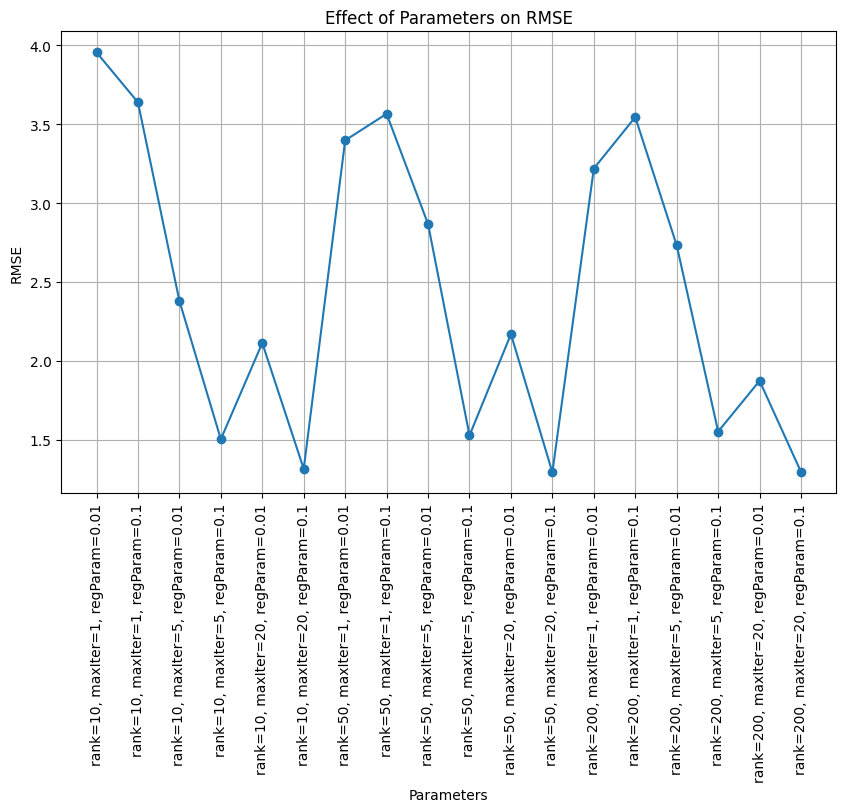

In [16]:
import matplotlib.pyplot as plt


param_labels = [f"rank={params['rank']}, maxIter={params['maxIter']}, regParam={params['regParam']}"
                for params in param_list]

plt.figure(figsize=(10, 6))
plt.plot(param_labels, rmse_values, marker="o")
plt.xlabel("Parameters")
plt.ylabel("RMSE")
plt.title("Effect of Parameters on RMSE")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [17]:
# RMSE değerlerine ve ilgili parametre kombinasyonlarına sahip olan bir liste oluşturun
rmse_param_list = list(zip(rmse_values, param_list))

# En küçük RMSE değerine sahip olan parametre kombinasyonunu seçin
best_rmse, best_params = min(rmse_param_list, key=lambda x: x[0])
print("MSE is a metric used to measure the average squared difference between the predicted values and the true values in a regression problem.")
print("RMSE is the square root of MSE, and it provides a metric that is in the same scale as the original target variable.")

print("The MSE and RMSE values represent the error rate. The best model is the one with the lowest values of these metrics. Therefore, based on this criterion, The best parameter combination:")
print(f"RMSE: {best_rmse}")
print(f"Rank: {best_params['rank']}, MaxIter: {best_params['maxIter']}, RegParam: {best_params['regParam']}")


MSE is a metric used to measure the average squared difference between the predicted values and the true values in a regression problem.
RMSE is the square root of MSE, and it provides a metric that is in the same scale as the original target variable.
The MSE and RMSE values represent the error rate. The best model is the one with the lowest values of these metrics. Therefore, based on this criterion, The best parameter combination:
RMSE: 1.2946339724178337
Rank: 50, MaxIter: 20, RegParam: 0.1


In [18]:
# Gerçek değerler ile tahminleri karşılaştırma
test_predictions = best_model.transform(test_data)
comparison = test_predictions.select("User_ID", "Movie_ID","Name", "Rating", "prediction")
comparison.show()


+-------+--------+--------------+------+----------+
|User_ID|Movie_ID|          Name|Rating|prediction|
+-------+--------+--------------+------+----------+
| 263031|     148|Sweet November|     5| 3.5333002|
| 754137|     148|Sweet November|     4| 1.7746369|
| 904455|     148|Sweet November|     3|  2.297125|
|1001129|     148|Sweet November|     3| 2.3765216|
|1017914|     148|Sweet November|     3| 3.0937083|
|1497891|     148|Sweet November|     2|  2.240175|
|1564927|     148|Sweet November|     5| 2.3496897|
|1718487|     148|Sweet November|     2|  2.809891|
|1750806|     148|Sweet November|     1| 2.6930883|
|2300163|     148|Sweet November|     5| 3.9024713|
|2311863|     148|Sweet November|     3| 3.2355187|
|  52264|     148|Sweet November|     2| 3.3874316|
| 901211|     148|Sweet November|     2| 2.2407868|
|1503725|     148|Sweet November|     3| 3.3414292|
|1515159|     148|Sweet November|     1|  2.044109|
|1712855|     148|Sweet November|     2| 2.3017442|
|1835914|   

In [19]:
import numpy as np
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession

def cosineSimilarity(user_id, a, b):
    dot = np.dot(a, b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = dot / (norma * normb)
    return user_id, cos

item_id = 148

item_factors = best_model.itemFactors
item_vector = item_factors.filter(item_factors.id == item_id).collect()
if not item_vector:
    raise ValueError(f"No factor vector for item_id {item_id}")
item_vector = item_vector[0]["features"]

sims = best_model.userFactors.rdd.map(lambda x: cosineSimilarity(x['id'], x['features'], item_vector))

top10_similar_users = sims.top(10, key=lambda x: x[1])

print(top10_similar_users)

[(51690, 0.9999999999999998), (1417990, 0.9999999999999998), (1553750, 0.9999999999999998), (508111, 0.9999999999999998), (748251, 0.9999999999999998), (1919701, 0.9999999999999998), (2191211, 0.9999999999999998), (2253871, 0.9999999999999998), (2287271, 0.9999999999999998), (732492, 0.9999999999999998)]


In [20]:
from pyspark.sql import Row

user_id = 2031561

users = spark.createDataFrame([Row(user_id=user_id)])

recommendations = best_model.recommendForUserSubset(users, numItems=10)

recommendations = recommendations.collect()[0]["recommendations"]

for recommendation in recommendations:
    movie_id = recommendation["Movie_ID"]
    rating = recommendation["rating"]
    print(f"Movie ID: {movie_id}, Rating: {rating}")

Movie ID: 253, Rating: 3.812014102935791
Movie ID: 197, Rating: 3.7051990032196045
Movie ID: 165, Rating: 3.5358362197875977
Movie ID: 270, Rating: 3.487565517425537
Movie ID: 359, Rating: 3.4370224475860596
Movie ID: 191, Rating: 3.424190044403076
Movie ID: 241, Rating: 3.4208264350891113
Movie ID: 76, Rating: 3.410930871963501
Movie ID: 152, Rating: 3.396789073944092
Movie ID: 143, Rating: 3.3912668228149414
